# Emotion detection in Facial Recognition

In [1]:
# !pip install dlib
# !pip install mtcnn

## Import necessary libraries

In [2]:
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from mtcnn import MTCNN

## Global variables

In [3]:
input_base_url = './'
images_url = os.path.join(input_base_url, 'images')
output_base_url = os.path.join(input_base_url, 'output')
organized_images_url = os.path.join(output_base_url, 'images')

In [4]:
# List of emotions
emotions = ['Happy', 'Neutral', 'Sad', 'Surprised', 'Disgust', 'Anger', 'Fear', 'Contempt']

## Organize the photos in emotions folders

In [5]:
if not os.path.exists(organized_images_url):
    os.makedirs(organized_images_url)
    
# Iterate through each numbered folder (0-18)
for folder_name in sorted(os.listdir(images_url)):
    folder_path = os.path.join(images_url, folder_name)
    if os.path.isdir(folder_path):  # Ensure it's a directory
        
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)
            
            if os.path.isfile(img_path):  # Ensure it's a file
                emotion_label = img_file.split('.')[0]  # Extract the emotion label
                
                if emotion_label in emotions:
                    destination_folder = os.path.join(organized_images_url, emotion_label)
                    if not os.path.exists(destination_folder):
                        os.makedirs(destination_folder)
                    
                    # Rename the image with folder name to avoid duplicates
                    new_img_name = f"{folder_name}_{img_file}"
                    destination_path = os.path.join(destination_folder, new_img_name)
                    
                    shutil.copy(img_path, destination_path)  # Copy instead of move
                    print(f"Copied {img_file} to {destination_path}")

print("Dataset successfully organized!")

Copied Happy.jpg to ./output/images/Happy/0_Happy.jpg
Copied Neutral.jpg to ./output/images/Neutral/0_Neutral.jpg
Copied Sad.jpg to ./output/images/Sad/0_Sad.jpg
Copied Surprised.jpg to ./output/images/Surprised/0_Surprised.jpg
Copied Disgust.jpg to ./output/images/Disgust/0_Disgust.jpg
Copied Anger.jpg to ./output/images/Anger/0_Anger.jpg
Copied Fear.jpg to ./output/images/Fear/0_Fear.jpg
Copied Contempt.jpg to ./output/images/Contempt/0_Contempt.jpg
Copied Happy.jpg to ./output/images/Happy/1_Happy.jpg
Copied Neutral.jpg to ./output/images/Neutral/1_Neutral.jpg
Copied Sad.jpg to ./output/images/Sad/1_Sad.jpg
Copied Surprised.jpg to ./output/images/Surprised/1_Surprised.jpg
Copied Disgust.jpg to ./output/images/Disgust/1_Disgust.jpg
Copied Anger.jpg to ./output/images/Anger/1_Anger.jpg
Copied Fear.jpg to ./output/images/Fear/1_Fear.jpg
Copied Contempt.jpg to ./output/images/Contempt/1_Contempt.jpg
Copied Happy.jpg to ./output/images/Happy/10_Happy.jpg
Copied Neutral.jpg to ./output/im

## Put the organized dataset in df

In [6]:
# Initialize an empty list to store data
data = []

# Iterate over emotion folders
for emotion in emotions:
    folder_path = os.path.join(organized_images_url, emotion)
    if os.path.exists(folder_path):
        for file_name in os.listdir(folder_path):
            if file_name.lower().endswith('.jpg'):
                image_path = os.path.join(folder_path, file_name)
                folder_name = file_name.split('_')[0]  # Extracting folder number from filename
                
                data.append({
                    'image_path': image_path,
                    'emotion': emotion,
                    'folder': folder_name
                })

# Create DataFrame
df = pd.DataFrame(data)

# Display first few rows
df.head()

,image_path,emotion,folder
0,./output/images/Happy/12_Happy.jpg,Happy,12
1,./output/images/Happy/0_Happy.jpg,Happy,0
2,./output/images/Happy/14_Happy.jpg,Happy,14
3,./output/images/Happy/6_Happy.jpg,Happy,6
4,./output/images/Happy/13_Happy.jpg,Happy,13


## Visualize all of the imgaes per emotion

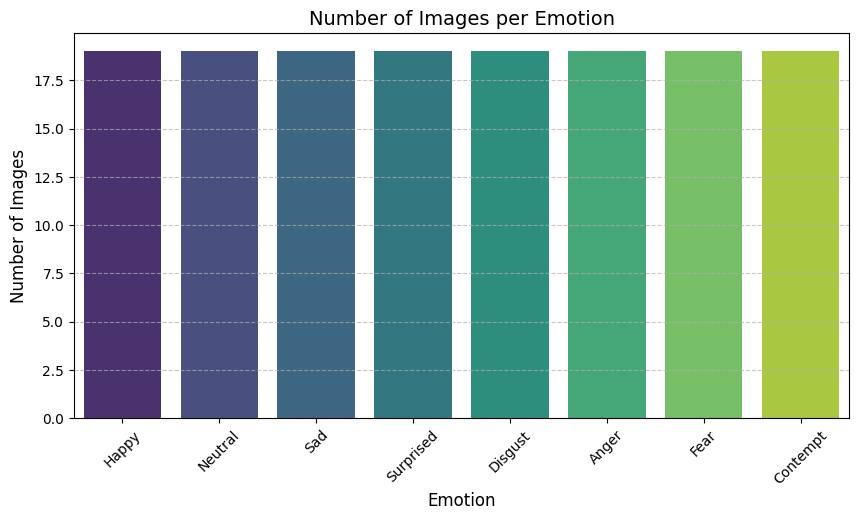

In [7]:
# Count number of images per emotion
emotion_counts = df['emotion'].value_counts()

# Plot the data
plt.figure(figsize=(10, 5))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="viridis", hue=emotion_counts.index, legend=False)

# Formatting
plt.title("Number of Images per Emotion", fontsize=14)
plt.xlabel("Emotion", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [8]:
# Initialize MTCNN detector
detector = MTCNN()

# Define cropped images folder
cropped_images_url = os.path.join(output_base_url, 'cropped_images')

# Remove and recreate the cropped images folder to avoid duplicates
if os.path.exists(cropped_images_url):
    shutil.rmtree(cropped_images_url)
os.makedirs(cropped_images_url)

# Process each emotion folder
for emotion in emotions:
    emotion_folder = os.path.join(organized_images_url, emotion)
    cropped_emotion_folder = os.path.join(cropped_images_url, emotion)
    
    os.makedirs(cropped_emotion_folder, exist_ok=True)

    for img_name in os.listdir(emotion_folder):
        img_path = os.path.join(emotion_folder, img_name)
        image = cv2.imread(img_path)

        if image is None:
            print(f"Skipping {img_name}, not a valid image.")
            continue

        # Convert image to RGB for MTCNN
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Detect faces
        detections = detector.detect_faces(image_rgb)

        if len(detections) == 0:
            print(f"No face detected in {img_name}, skipping...")
            continue

        # Get the bounding box of the first detected face
        x, y, w, h = detections[0]['box']
        cropped_face = image[y:y+h, x:x+w]

        # Save cropped image
        cropped_img_path = os.path.join(cropped_emotion_folder, img_name)
        cv2.imwrite(cropped_img_path, cropped_face)
        print("Cropped the image", img_name, emotion)

print("Face cropping completed!")

Cropped the image 12_Happy.jpg Happy
Cropped the image 0_Happy.jpg Happy
Cropped the image 14_Happy.jpg Happy
Cropped the image 6_Happy.jpg Happy
Cropped the image 13_Happy.jpg Happy
Cropped the image 1_Happy.jpg Happy
Cropped the image 15_Happy.jpg Happy
Cropped the image 7_Happy.jpg Happy
Cropped the image 18_Happy.jpg Happy
Cropped the image 10_Happy.jpg Happy
Cropped the image 2_Happy.jpg Happy
Cropped the image 16_Happy.jpg Happy
Cropped the image 9_Happy.jpg Happy
Cropped the image 4_Happy.jpg Happy
Cropped the image 11_Happy.jpg Happy
Cropped the image 3_Happy.jpg Happy
Cropped the image 17_Happy.jpg Happy
Cropped the image 8_Happy.jpg Happy
Cropped the image 5_Happy.jpg Happy
Cropped the image 3_Neutral.jpg Neutral
Cropped the image 17_Neutral.jpg Neutral
Cropped the image 6_Neutral.jpg Neutral
Cropped the image 12_Neutral.jpg Neutral
Cropped the image 11_Neutral.jpg Neutral
Cropped the image 5_Neutral.jpg Neutral
Cropped the image 18_Neutral.jpg Neutral
Cropped the image 9_Neu